<a href="https://colab.research.google.com/github/airctic/icevision/blob/master/notebooks/using_swin_transformer_as_backbone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Swin Transformer as backbone in IceVision

Exciting News: Now you can use both VFNet and RetinaNet with 3 different pretrained Swin Transformer backbones.

Spectacular results with VFNet. COCO metric reached 66% vs 34% for RetinaNet when training the Fridge Object Dataset

Both the neck (FPN) and the head are trained from scratch!

![](https://media-exp1.licdn.com/dms/image/C4E22AQE4UwSy9xbQPg/feedshare-shrink_2048_1536/0/1644117293076?e=1646870400&v=beta&t=MA_QZSTFGHWvMRO7FWOMFOk9m8YPIYB00g2wxnEtVsQ)

## Introduction
[Swin Transformer](https://openaccess.thecvf.com/content/ICCV2021/papers/Liu_Swin_Transformer_Hierarchical_Vision_Transformer_Using_Shifted_Windows_ICCV_2021_paper.pdf) currently holds state-of-the-art [results](https://paperswithcode.com/paper/swin-transformer-hierarchical-vision) in prominent computer vision benchmark datasets:
> 1. Image classification: 87.3 top-1 accuracy on ImageNet-1K
> 2. Object detection: 58.7 box AP and 51.1 mask AP on COCO testdev
> 3. Semantic segmentation: 53.5 mIoU on ADE20K val

Its performance surpasses the previous state-of-theart by a large margin of +2.7 box AP and +2.6 mask AP on
COCO, and +3.2 mIoU on ADE20K, demonstrating the potential of Transformer-based models as vision backbones.

IceVision now supports using Swin Transformer as backbone for some models.

In this tutorial, you will learn how to:
1. Use the IceVision `mmdet` models with the Swin Transformer as backbone
2. Instantiate the model, and then train it with both the fastai and pytorch lightning engines.  
3. And finally, use the model to identify objects in images.  

## Install IceVision and IceData
The following downloads and runs a short shell script. The script installs IceVision, IceData, the MMDetection library, and Yolo v5 as well
as the fastai and pytorch lightning engines.

Install from pypi...

In [ ]:
# Torch - Torchvision - IceVision - IceData - MMDetection - YOLOv5 - EfficientDet Installation
!wget https://raw.githubusercontent.com/airctic/icevision/master/icevision_install.sh

# Choose your installation target: cuda11 or cuda10 or cpu
!bash icevision_install.sh cuda11

--2022-06-20 10:14:10--  https://raw.githubusercontent.com/airctic/icevision/master/icevision_install.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2766 (2.7K) [text/plain]
Saving to: ‘icevision_install.sh’

icevision_install.s 100%[===================>]   2.70K  --.-KB/s    in 0s      

2022-06-20 10:14:10 (27.0 MB/s) - ‘icevision_install.sh’ saved [2766/2766]

Installing icevision + dependencices for cuda11
- Installing torch and its dependencies
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████▌                   | 834.1 MB 1.6 MB/s eta 0:13:50tcmalloc: large alloc 1147494400 bytes == 0x399ea000 @  0x7f17eaa80615 0x

... or from icevision master

In [ ]:
# # Torch - Torchvision - IceVision - IceData - MMDetection - YOLOv5 - EfficientDet Installation
# !wget https://raw.githubusercontent.com/airctic/icevision/master/icevision_install.sh

# # Choose your installation target: cuda11 or cuda10 or cpu
# !bash icevision_install.sh cuda11 master

In [ ]:
# Restart kernel after installation
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

{'restart': True, 'status': 'ok'}

In [ ]:
import IPython

In [ ]:
import wandb
from fastai.callback.wandb import *
from fastai.callback.tracker import SaveModelCallback

## Imports
All of the IceVision components can be easily imported with a single line.


In [ ]:
from icevision.all import *

INFO     - Downloading default `.ttf` font file - SpaceGrotesk-Medium.ttf from https://raw.githubusercontent.com/airctic/storage/master/SpaceGrotesk-Medium.ttf to /root/.icevision/fonts/SpaceGrotesk-Medium.ttf | icevision.visualize.utils:get_default_font:70
INFO     - Downloading mmdet configs | icevision.models.mmdet.download_configs:download_mmdet_configs:31


0B [00:00, ?B/s]

## Download and prepare a dataset
Now we can start by downloading the Fridge Objects dataset. This tiny dataset contains 134 images of 4 classes:
- can, 
- carton, 
- milk bottle, 
- water bottle.

IceVision provides methods to load a dataset, parse annotation files, and more.

For more information about how the fridge dataset as well as its corresponding parser, check out the [fridge folder](https://github.com/airctic/icedata/tree/master/icedata/datasets/fridge) in icedata.

In [ ]:
# Download the dataset
url = "https://cvbp-secondary.z19.web.core.windows.net/datasets/object_detection/odFridgeObjects.zip"
dest_dir = "fridge"
data_dir = icedata.load_data(url, dest_dir)

  0%|          | 0/20380998 [00:00<?, ?B/s]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Parse the dataset

The parser loads the annotation file and parses them returning a list of training and validation records. The parser has an extensible `autofix` capability that identifies common errors in annotation files, reports, and often corrects them automatically.

The parsers support multiple formats (including VOC and COCO). You can also extend the parser for additional formats if needed.

The record is a key concept in IceVision, it holds the information about an image and its annotations. It is extensible and can support other object formats and types of annotations.


In [ ]:
# Create the parser
parser = parsers.VOCBBoxParser(annotations_dir=data_dir / "/content/drive/MyDrive/aibuilder/embrio1/train/voc_annotations", images_dir=data_dir / "/content/drive/MyDrive/aibuilder/embrio1/train/images")

In [ ]:
from icevision.data import data_splitter
data_splitter = RandomSplitter([0.8, 0.2])

In [ ]:
# Parse annotations to create records
train_records, valid_records = parser.parse()
parser.class_map

  0%|          | 0/2700 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


  0%|          | 0/2700 [00:00<?, ?it/s]

<ClassMap: {'background': 0, 'Basophil': 1, 'Atypical lymphocyte': 2, 'NRC': 3, 'Segmented neutrophil': 4, 'Blast': 5, 'Promyelocyte': 6, 'Myelocyte': 7, 'Lymphocyte': 8, 'Band Neutrophil': 9, 'Metamyelocyte': 10, 'Monocyte': 11, 'Eosinophil': 12}>

In [ ]:
parser.class_map

<ClassMap: {'background': 0, 'Basophil': 1, 'Atypical lymphocyte': 2, 'NRC': 3, 'Segmented neutrophil': 4, 'Blast': 5, 'Promyelocyte': 6, 'Myelocyte': 7, 'Lymphocyte': 8, 'Band Neutrophil': 9, 'Metamyelocyte': 10, 'Monocyte': 11, 'Eosinophil': 12}>

## Creating datasets with augmentations and transforms

Data augmentations are essential for robust training and results on many datasets and deep learning tasks. IceVision ships with the [Albumentations](https://albumentations.ai/docs/) library for defining and executing transformations, but can be extended to use others.

For this tutorial, we apply the Albumentation's default `aug_tfms` to the training set. `aug_tfms` randomly applies broadly useful transformations including rotation, cropping, horizintal flips, and more. See the Albumentations documentation to learn how to customize each transformation more fully.

The validation set is only resized (with padding).

We then create `Datasets` for both. The dataset applies the transforms to the annotations (such as bounding boxes) and images in the data records.

In [ ]:
# Transforms
image_size = 384
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=image_size, presize=512), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(image_size), tfms.A.Normalize()])

In [ ]:
# Datasets
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

### Understanding the transforms

The Dataset transforms are only applied when we grab (get) an item. Several of the default `aug_tfms` have a random element to them. For example, one might perform a rotation with probability 0.5 where the angle of rotation  is randomly selected between +45 and -45 degrees.

This means that the learner sees a slightly different version of an image each time it is accessed. This effectively increases the size of the dataset and improves learning.

We can look at result of getting the 0th image from the dataset a few times and see the differences. Each time you run the next cell, you will see different results due to the random element in applying transformations.

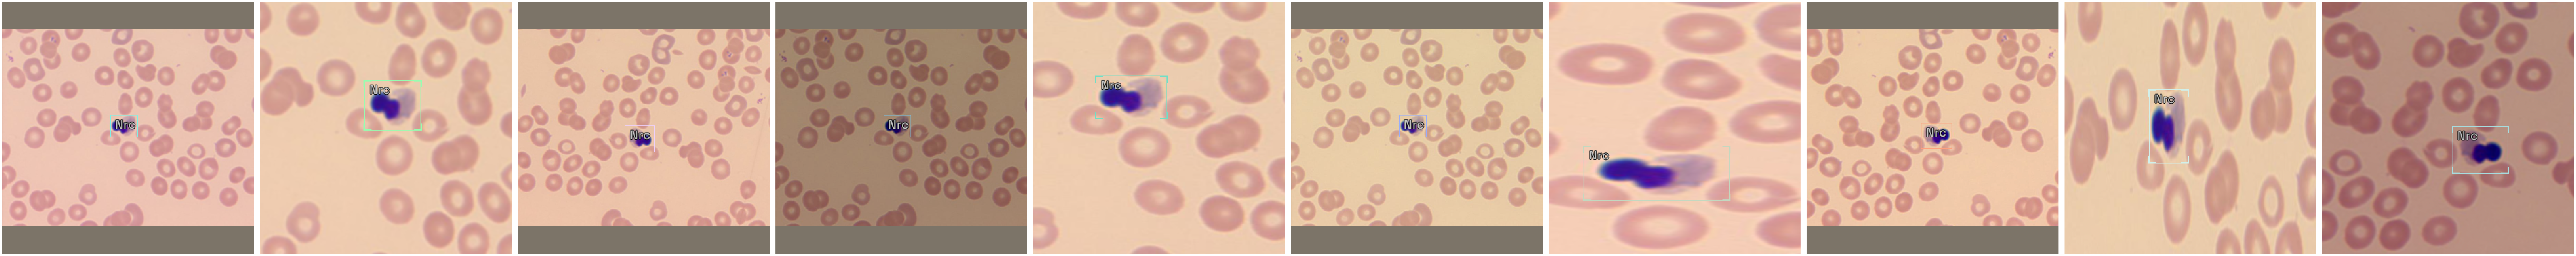

In [ ]:
# Show an element of the train_ds with augmentation transformations applied
samples = [train_ds[0] for _ in range(10)]
show_samples(samples, ncols=10)

## Select a library, model, and backbone

In order to create a model, we need to:
* Choose one of the **libraries** supported by IceVision
* Choose one of the **models** supported by the library
* Choose one of the **backbones** corresponding to a chosen model

You can access any supported models by following the IceVision unified API, use code completion to explore the available models for each library.



### Creating a model
Presently IceVision only supports the `mmdet` implementation of RetinaNet and VFNet (for object detection) and MaskRCNN (for instance segmentation) to use the Swin Transformer backbone. The model and backbone can be selected as follows:

```
model_type = models.mmdet.vfnet
backbone = model_type.backbones.swin_t_p4_w7_fpn_1x_coco
```

There are currently 3 available backbones namely `swin_t_p4_w7_fpn_1x_coco`,`swin_s_p4_w7_fpn_1x_coco` and `swin_b_p4_w7_fpn_1x_coco`.

In [ ]:
model_type = models.mmdet.vfnet
backbone = model_type.backbones.swin_b_p4_w7_fpn_1x_coco

In [ ]:
# Just change the value of selection to try another model

selection = 1

extra_args = {}

if selection == 0:
  model_type = models.mmdet.vfnet
  backbone = model_type.backbones.swin_t_p4_w7_fpn_1x_coco

if selection == 1:
  model_type = models.mmdet.retinanet
  backbone = model_type.backbones.swin_s_p4_w7_fpn_1x_coco

if selection == 2:
  model_type = models.mmdet.vfnet
  backbone = model_type.backbones.swin_b_p4_w7_fpn_1x_coco

model_type, backbone, extra_args

(<module 'icevision.models.mmdet.models.vfnet' from '/usr/local/lib/python3.7/dist-packages/icevision/models/mmdet/models/vfnet/__init__.py'>,
 {})

In [ ]:
backbone.__dict__

{'model_name': 'yolov5s', 'pretrained': True}

### Wandb

In [ ]:
wandb.init(project="icevision-fridge", name="swin_b", reinit=True)

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc



Now it is just a one-liner to instantiate the model. If you want to try another *option*, just edit the line at the top of the previous cell.

In [ ]:
# Instantiate the model
model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(parser.class_map)) 

TypeError: ignored

The current Swin Transformer implementation only provides pretrained weights for the backbone. 

> **_Note:_** For the Swin Transformer model `pretrained=True` indicates that only the backbone is pretrained. The neck and the head of the model will be trained from scratch.

## Data Loader

The Data Loader is specific to a model_type. The job of the data loader is to get items from a dataset and batch them up in the specific format required by each model. This is why creating the data loaders is separated from creating the datasets.

We can take a look at the first batch of items from the `valid_dl`. Remember that the `valid_tfms` only resized (with padding) and normalized records, so different images, for example, are not returned each time. This is important to provide consistent validation during training.

In [ ]:
# Data Loaders
train_dl = model_type.train_dl(train_ds, batch_size=8, num_workers=4, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=8, num_workers=4, shuffle=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


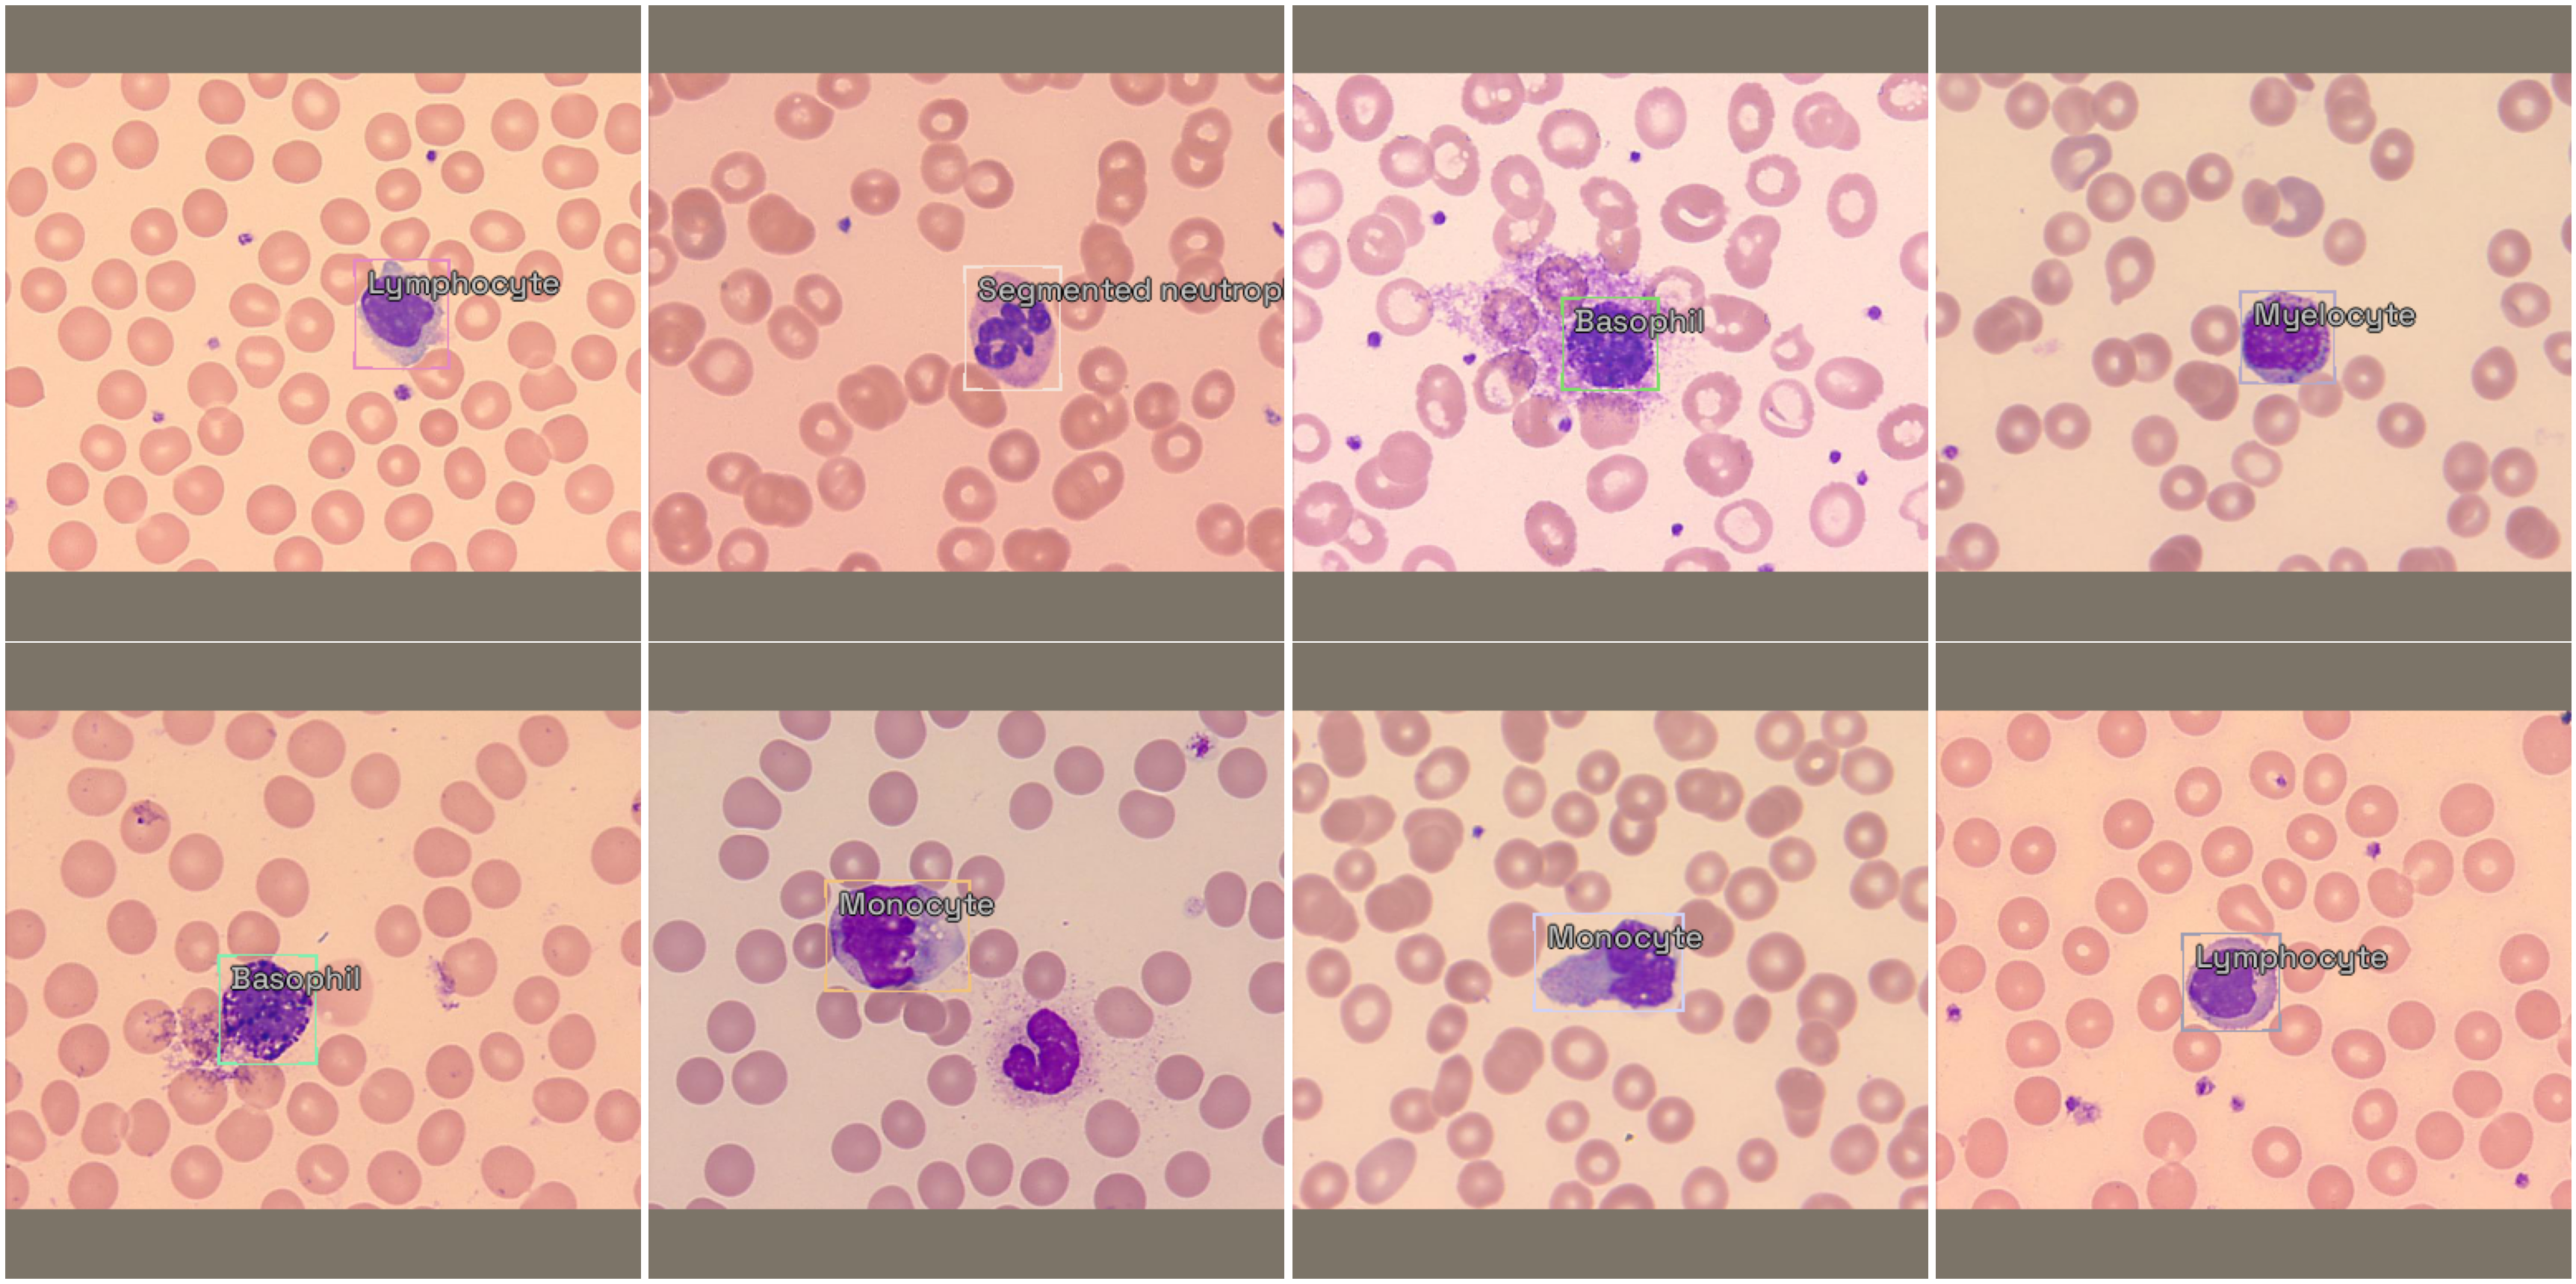

In [ ]:
# show batch
model_type.show_batch(first(valid_dl), ncols=4)

## Metrics

The fastai and pytorch lightning engines collect metrics to track progress during training. IceVision provides metric classes that work across the engines and libraries.

The same metrics can be used for both fastai and pytorch lightning.

In [ ]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox), SimpleConfusionMatrix(print_summary=True)]

In [ ]:
from icevision.metrics.confusion_matrix.confusion_matrix import *

## Training

IceVision is an agnostic framework meaning it can be plugged into other DL learning engines such as [fastai2](https://github.com/fastai/fastai2), and [pytorch-lightning](https://github.com/PyTorchLightning/pytorch-lightning).  


### Training using fastai

In [ ]:
learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

In [ ]:
learn.lr_find(end_lr=0.005)

NameError: ignored

In [ ]:
learn.fine_tune(10,1e-6, freeze_epochs=1)

/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 31  0  0  0  0  0  1  0  0  0  0  1]
 [ 0  0 38  0  0  1  0  0  4  1  0  5  0]
 [ 9  0  1 40  1  2  0  0  3  0  2  0  0]
 [ 1  0  0  0 22  0  0  0  0 20  0  0  0]
 [10  0  2  0  0 73  0  0  1  0  1  1  0]
 [ 2  0  0  0  0 14  7  4  0  0  2  0  0]
 [ 5  0  1  0  0  0  1 27  0  3 22  5  0]
 [ 0  0  6  2  0  1  0  0 28  0  0  0  0]
 [ 2  1  0  0 11  0  0  1  0 47  4  1  0]
 [ 0  0  0  0  0  0  0 10  0  1 40  4  0]
 [ 1  0  3  0  0  1  0  2  3  7  1 39  0]
 [ 1  0  0  0  0  0  0  0  0  0  1  2 48]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 31  0  0  0  0  0  2  0  0  0  0  1]
 [ 0  0 38  0  0  1  0  0  4  1  0  5  0]
 [ 9  0  1 40  1  2  0  0  3  0  2  0  0]
 [ 1  0  0  0 22  0  0  0  0 20  0  0  0]
 [10  0  2  0  0 73  0  0  1  0  1  1  0]
 [ 2  0  0  0  0 14  7  4  0  0  2  0  0]
 [ 5  0  1  0  0  0  1 27  0  3 22  5  0]
 [ 0  0  6  2  0  1  0  0 28  0  0  0  0]
 [ 2  1  0  0 10  0  0  1  0 48  4  1  0]
 [ 0  0  0  0  0  0  0 10  0  1 40  4  0]
 [ 1  0  3  0  0  1  0  2  3  7  1 39  0]
 [ 1  0  0  0  0  0  0  0  0  1  1  2 47]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 31  0  0  0  0  0  2  0  0  0  0  1]
 [ 0  0 38  0  0  1  0  0  4  1  0  5  0]
 [ 9  0  1 40  1  2  0  0  3  0  2  0  0]
 [ 1  0  0  0 22  0  0  0  0 20  0  0  0]
 [10  0  2  0  0 73  0  0  1  0  1  1  0]
 [ 2  0  0  0  0 14  7  4  0  0  2  0  0]
 [ 5  0  1  0  0  0  1 27  0  3 22  5  0]
 [ 0  0  6  2  0  1  0  0 28  0  0  0  0]
 [ 2  2  0  0 11  0  0  1  0 46  4  1  0]
 [ 0  0  0  0  0  0  0 10  0  1 41  3  0]
 [ 1  0  3  0  0  1  0  3  3  7  3 36  0]
 [ 1  0  0  0  0  0  0  0  0  0  1  2 48]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 31  0  0  0  0  0  2  0  0  0  0  1]
 [ 0  0 37  0  0  1  0  0  5  1  0  5  0]
 [ 9  0  1 40  1  2  0  0  3  0  2  0  0]
 [ 1  0  0  0 22  0  0  0  0 20  0  0  0]
 [10  0  3  0  0 73  0  0  0  0  1  1  0]
 [ 1  0  0  0  0 14  8  4  0  0  2  0  0]
 [ 5  0  1  0  0  0  1 27  0  3 22  5  0]
 [ 0  0  6  2  0  1  0  0 28  0  0  0  0]
 [ 2  2  0  0 10  0  0  1  0 47  4  1  0]
 [ 0  0  0  0  0  0  0 10  0  1 41  3  0]
 [ 1  0  3  0  0  1  0  3  3  7  2 37  0]
 [ 1  0  0  0  0  0  0  0  0  0  1  2 48]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 32  0  0  0  0  0  2  0  0  0  0  0]
 [ 0  0 38  0  0  1  0  0  4  1  0  5  0]
 [ 9  0  1 40  1  2  0  0  3  0  2  0  0]
 [ 1  0  0  0 22  0  0  0  0 20  0  0  0]
 [ 9  0  3  0  0 74  0  0  0  0  1  1  0]
 [ 2  0  0  0  0 14  7  4  0  0  2  0  0]
 [ 5  0  1  0  0  0  1 28  0  3 21  5  0]
 [ 0  0  6  2  0  1  0  0 28  0  0  0  0]
 [ 2  2  0  0 11  0  0  1  0 46  4  1  0]
 [ 0  0  0  0  0  0  0 10  0  1 40  4  0]
 [ 1  0  3  0  0  1  0  3  3  7  2 37  0]
 [ 1  0  0  0  0  0  0  0  0  0  1  2 48]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 32  0  0  0  0  0  2  0  0  0  0  0]
 [ 0  0 38  0  0  2  0  0  4  1  0  4  0]
 [ 9  0  1 40  1  2  0  0  3  0  2  0  0]
 [ 1  0  0  0 22  0  0  0  0 20  0  0  0]
 [ 9  0  2  0  0 74  0  0  1  0  1  1  0]
 [ 1  0  0  0  0 14  8  4  0  0  2  0  0]
 [ 5  0  1  0  0  0  1 28  0  3 21  5  0]
 [ 0  0  6  1  0  1  0  0 29  0  0  0  0]
 [ 2  2  0  0 10  0  0  1  0 47  4  1  0]
 [ 0  0  0  0  0  0  0 10  0  0 41  4  0]
 [ 1  0  3  0  0  1  0  3  3  6  1 39  0]
 [ 1  0  0  0  0  0  0  0  0  0  1  2 48]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 32  0  0  0  0  0  2  0  0  0  0  0]
 [ 0  0 37  0  0  1  0  0  5  1  0  5  0]
 [ 9  0  1 40  1  2  0  0  3  0  2  0  0]
 [ 1  0  0  0 22  0  0  0  0 20  0  0  0]
 [10  0  3  0  0 73  0  0  0  0  1  1  0]
 [ 1  0  0  0  0 14  8  4  0  0  2  0  0]
 [ 5  0  1  0  0  0  1 28  0  3 21  5  0]
 [ 0  0  5  2  0  1  0  0 29  0  0  0  0]
 [ 2  2  0  0 11  0  0  1  0 46  4  1  0]
 [ 0  0  0  0  0  0  0 10  0  1 41  3  0]
 [ 1  0  3  0  0  1  0  4  3  7  3 35  0]
 [ 1  0  0  0  0  0  0  1  0  0  1  1 48]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 32  0  0  0  0  0  2  0  0  0  0  0]
 [ 0  0 37  0  0  1  0  0  5  1  0  5  0]
 [ 9  0  1 40  1  2  0  0  3  0  2  0  0]
 [ 1  0  0  0 22  0  0  0  0 20  0  0  0]
 [ 9  0  3  0  0 74  0  0  0  0  1  1  0]
 [ 1  0  0  0  0 14  8  4  0  0  2  0  0]
 [ 5  0  1  0  0  0  1 28  0  3 21  5  0]
 [ 0  0  5  2  0  1  0  0 29  0  0  0  0]
 [ 2  2  0  0 12  0  0  1  0 45  4  1  0]
 [ 0  0  0  0  0  0  0 10  0  1 41  3  0]
 [ 1  0  3  0  0  1  0  3  3  7  3 36  0]
 [ 1  0  0  0  0  0  0  0  0  0  1  2 48]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 32  0  0  0  0  0  2  0  0  0  0  0]
 [ 0  0 37  0  0  1  0  0  5  1  0  5  0]
 [ 9  0  1 40  1  2  0  0  3  0  2  0  0]
 [ 1  0  0  0 22  0  0  0  0 20  0  0  0]
 [ 9  0  3  0  0 74  0  0  0  0  1  1  0]
 [ 1  0  0  0  0 14  8  4  0  0  2  0  0]
 [ 5  0  1  0  0  0  1 28  0  3 21  5  0]
 [ 0  0  5  2  0  1  0  0 29  0  0  0  0]
 [ 2  2  0  0 11  0  0  1  0 46  4  1  0]
 [ 0  0  0  0  0  0  0 10  0  1 40  4  0]
 [ 1  0  3  0  0  1  0  3  3  7  1 38  0]
 [ 1  0  0  0  0  0  0  0  0  0  1  2 48]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 32  0  0  0  0  0  2  0  0  0  0  0]
 [ 0  0 37  0  0  1  0  0  5  1  0  5  0]
 [ 9  0  1 40  1  2  0  0  3  0  2  0  0]
 [ 1  0  0  0 22  0  0  0  0 20  0  0  0]
 [10  0  3  0  0 73  0  0  0  0  1  1  0]
 [ 1  0  0  0  0 14  8  4  0  0  2  0  0]
 [ 5  0  1  0  0  0  1 28  0  3 21  5  0]
 [ 0  0  5  2  0  1  0  0 29  0  0  0  0]
 [ 2  2  0  0 12  0  0  1  0 45  4  1  0]
 [ 0  0  0  0  0  0  0 10  0  1 40  4  0]
 [ 1  0  3  0  0  1  0  3  3  7  2 37  0]
 [ 1  0  0  0  0  0  0  0  0  0  1  2 48]]


/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:324: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/usr/local/lib/python3.7/dist-packages/mmdet/core/anchor/anchor_generator.py:361: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '


[[ 0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 32  0  0  0  0  0  2  0  0  0  0  0]
 [ 0  0 37  0  0  1  0  0  5  1  0  5  0]
 [ 9  0  1 40  1  2  0  0  3  0  2  0  0]
 [ 1  0  0  0 22  0  0  0  0 20  0  0  0]
 [10  0  3  0  0 73  0  0  0  0  1  1  0]
 [ 1  0  0  0  0 14  8  4  0  0  2  0  0]
 [ 5  0  1  0  0  0  1 28  0  3 21  5  0]
 [ 0  0  5  2  0  1  0  0 29  0  0  0  0]
 [ 2  2  0  0 12  0  0  1  0 45  4  1  0]
 [ 0  0  0  0  0  0  0 10  0  1 40  4  0]
 [ 1  0  3  0  0  1  0  3  3  7  2 37  0]
 [ 1  0  0  0  0  0  0  0  0  0  1  2 48]]


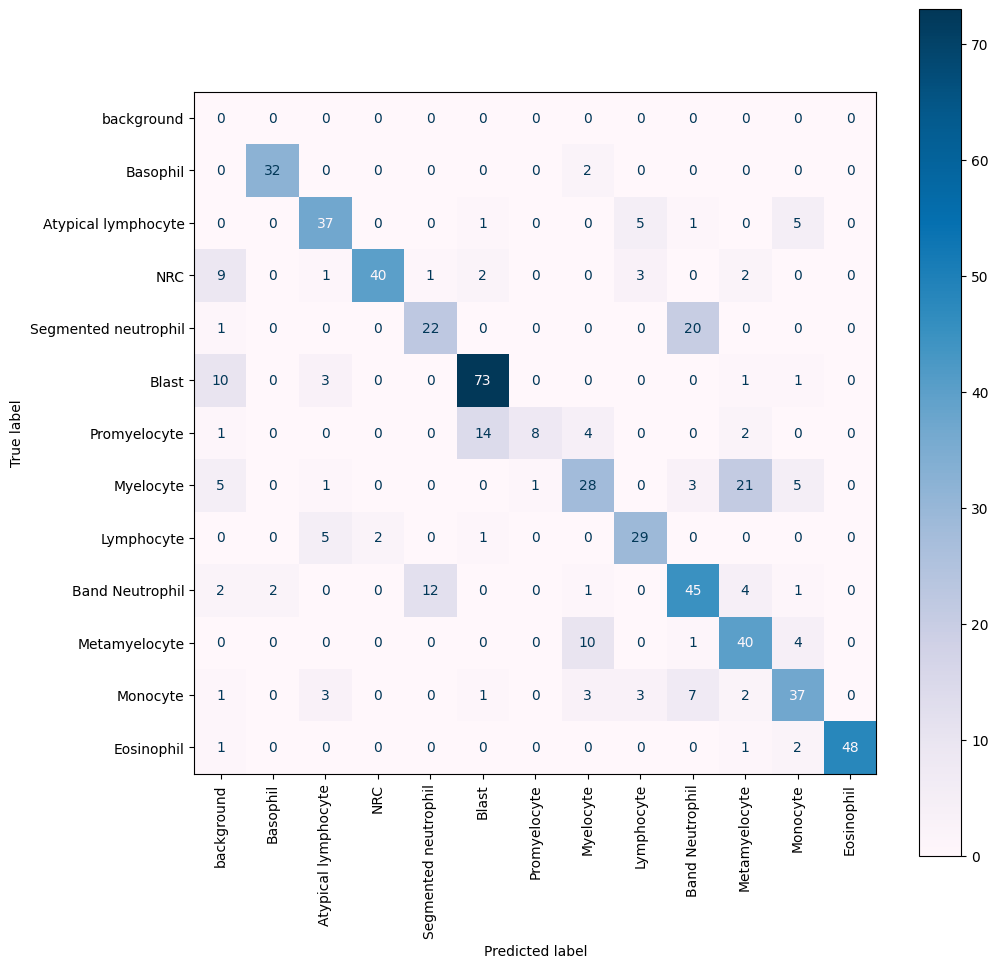

In [ ]:
learn.metrics[1].metric.plot()

In our tests, the VFNet + Swin-T backbone scored over 66% on the `COCOMetric` for this dataset. Not bad at all for a model with an untrained neck and head!

### Training using Pytorch Lightning

In [ ]:
class LightModel(model_type.lightning.ModelAdapter):
    def configure_optimizers(self):
        return Adam(self.parameters(), lr=1e-4)
    
light_model = LightModel(model, metrics=metrics)

In [ ]:
trainer = pl.Trainer(max_epochs=100, gpus=1)
trainer.fit(light_model, train_dl, valid_dl)

## Using the model - inference and showing results

The first step in reviewing the model is to show results from the validation dataset. This is easy to do with the `show_results` function.

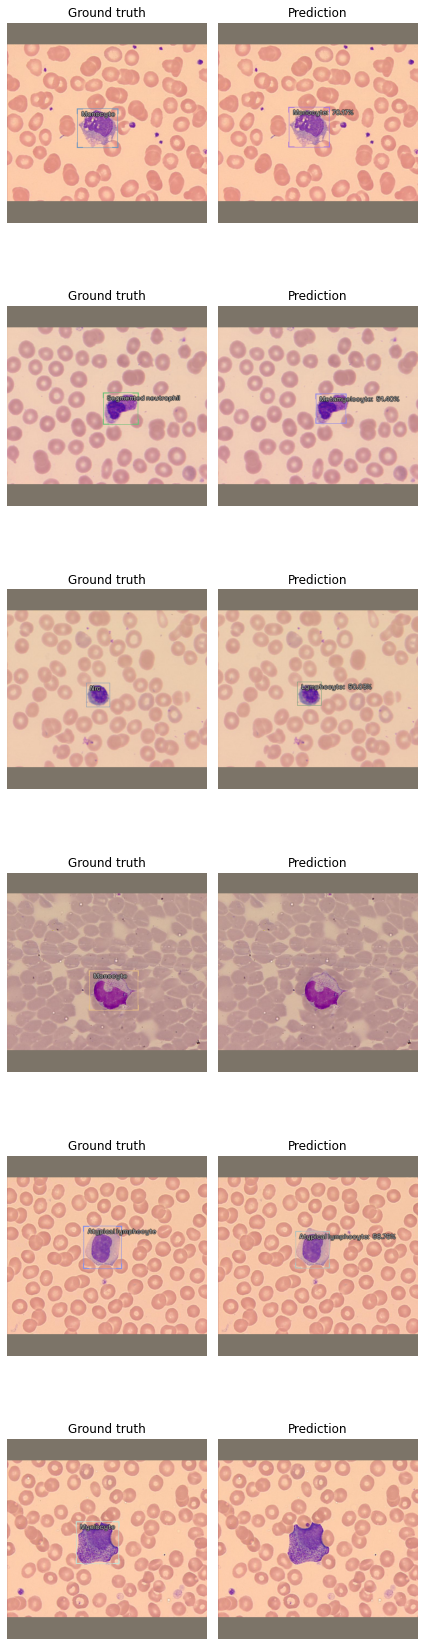

In [ ]:
model_type.show_results(model, valid_ds, detection_threshold=.5)

### Prediction

Sometimes you want to have more control than `show_results` provides. You can construct an inference dataloader using `infer_dl` from any IceVision dataset and pass this to `predict_dl` and use `show_preds` to look at the predictions.

A prediction is returned as a dict with keys: `scores`, `labels`, `bboxes`, and possibly `masks`. 

Prediction functions that take a `detection_threshold` argument will only return the predictions whose score is above the threshold.

Prediction functions that take a `keep_images` argument will only return the (tensor representation of the) image when it is `True`. In interactive environments, such as a notebook, it is helpful to see the image with bounding boxes and labels applied. In a deployment context, however, it is typically more useful (and efficient) to return the bounding boxes by themselves.



> NOTE: For a more detailed look at inference check out the [inference tutorial](https://airctic.com/dev/inference/)

In [ ]:
infer_dl = model_type.infer_dl(valid_ds, batch_size=4, shuffle=False)
preds = model_type.predict_from_dl(model, infer_dl, keep_images=True)

  0%|          | 0/135 [00:00<?, ?it/s]

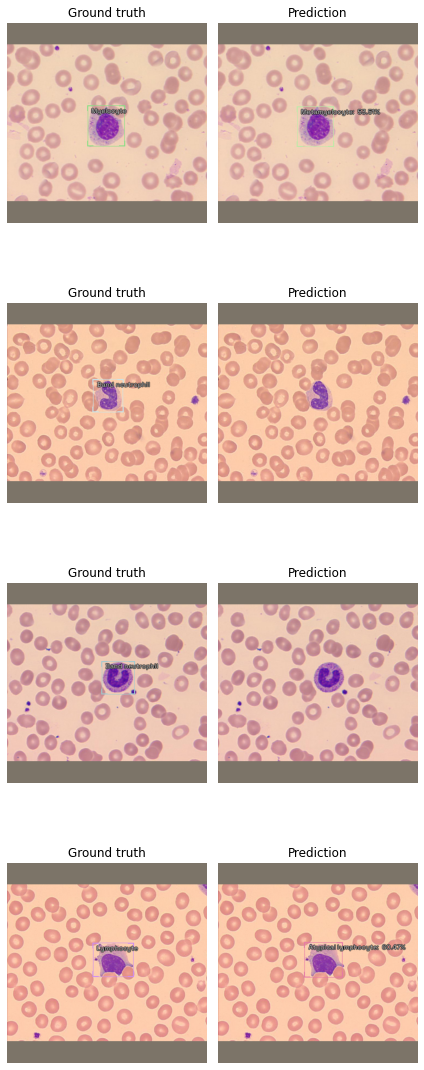

In [ ]:
show_preds(preds=preds[:4])

## Save the model

In [ ]:
from icevision.models import *

In [ ]:
m = ClassMap(['Basophil', 'Atypical lymphocyte', 'NRC', 'Segmented neutrophil', 'Blast', 'Promyelocyte', 'Myelocyte', 'Lymphocyte', 'Band Neutrophil', 'Metamyelocyte', 'Monocyte', 'Eosinophil'])
m.get_classes()

['background',
 'Basophil',
 'Atypical lymphocyte',
 'NRC',
 'Segmented neutrophil',
 'Blast',
 'Promyelocyte',
 'Myelocyte',
 'Lymphocyte',
 'Band Neutrophil',
 'Metamyelocyte',
 'Monocyte',
 'Eosinophil']

In [ ]:
model_type = models.mmdet.vfnet
backbone = model_type.backbones.swin_b_p4_w7_fpn_1x_coco

In [ ]:
from icevision.models import *

# Save The Model
checkpoint_path = 'swin-WB-checkpoint-full_s.pth'

save_icevision_checkpoint(model, 
                        model_name='mmdet.vfnet', 
                        backbone_name='swin_b_p4_w7_fpn_1x_coco',
                        classes =  m.get_classes(),
                        img_size=image_size, 
                        filename=checkpoint_path,
                        meta={'icevision_version': '0.12.0'})

## Test

In [ ]:
checkpoint_path = 'coco-retinanet-checkpoint-full.pth'
checkpoint_and_model = model_from_checkpoint(checkpoint_path)

## Happy Learning!

If you need any assistance, feel free to join our [forum](https://discord.gg/JDBeZYK).